In [12]:
import pandas as pd
import numpy as np
import os
import sys

import pickle
from datetime import datetime


from scipy.stats import ttest_ind, mannwhitneyu


import tensorflow as tf

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

# preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


# Reshaping 
from tensorflow import reshape
from tensorflow.image import resize_with_pad


# Modelling 
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

# Transfer learning
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.applications import MobileNetV2

# metrics
from tensorflow.keras.metrics import Recall, AUC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc

%matplotlib inline



module_path = os.path.abspath(os.path.join('src'))
if module_path not in sys.path:
    sys.path.append(module_path)
# Custom modules 
from modules import data, graphs, eda
plt.style.use('ggplot')
np.random.seed(42)

# Check class imbalance and look at examples from each

In [ ]:
train_dir = './src/data/train/' # image folder

# get the list of jpegs from sub image class folders
normal_imgs = [fn for fn in os.listdir(f'{train_dir}/NORMAL') if fn.endswith('.jpeg')]
pneumo_imgs = [fn for fn in os.listdir(f'{train_dir}/PNEUMONIA') if fn.endswith('.jpeg')]

# randomly select 3 of each
select_norm = np.random.choice(normal_imgs, 3, replace = False)
select_pneu = np.random.choice(pneumo_imgs, 3, replace = False)


normal_size = len(normal_imgs)/(len(normal_imgs)+len(pneumo_imgs))
pnue_size = len(pneumo_imgs)/(len(normal_imgs)+len(pneumo_imgs))

ax = sns.barplot(x = ['Normal', 'Pneumonia'],
                 y = [normal_size, pnue_size]);
ax.set_title("Class Imbalance");
plt.savefig("./images/classimbalance.png" ,bbox_inches='tight')

# plotting 3 of each class 
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/NORMAL/{select_norm[i]}'
        label = 'NORMAL'
    else:
        fp = f'{train_dir}/PNEUMONIA/{select_pneu[i-3]}'
        label = 'PNEUMONIA'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (100,100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.savefig("./images/normVSpneu.png" ,bbox_inches='tight')    
plt.show()


The first thing to note is that we have a class imbalance between healthy and pnuemonia patients where there are fewer healthy picture than ones with pnuemonia. In medical imaging this is a common occurance. The people who are sicker are more likely to recieve chest x rays and therefore we would expect there to be a higher number of x rays featuring patients with pnueomonia.

The image above shows three healthy chest xrays and three chest xrays of patients with pneumonia. Patients with pnuemonia have less defined organ structures. There is generally a "haze" around the lung area. This haze is caused by a build up of fluid and scarring caused by bacterial or viral infections causing the pnuemonia.

However, this is just a small sample, in fact, the central pneuomonia image is take from the side whereas the other 5 images are taken from the anterior to posterior axis.

To see if there are differences in the in the xrays of sick versus healthy patients overall, calculated the mean value for each pixel in the image array and took the mean of those pixels.

To do this, we imported each picture seperately, adjusted their size so that they are all 224,224 and converted them to grayscale. We then flattened the two dimensional array to 1 dimension using np.ravel() and concatenated all of the vectors into one matrix call full_mat (full_matrix).

Once we had our full matrix, we took the mean accross each row (matching pixels in the image) concatenated them into an n X m matrix

In [10]:
# making n X m matrix
# run it on our folders
normal_images = eda.image_to_matrix(f'{train_dir}/NORMAL/', normal_imgs)
pnemonia_images = eda.image_to_matrix(f'{train_dir}/PNEUMONIA/', pneumo_imgs)

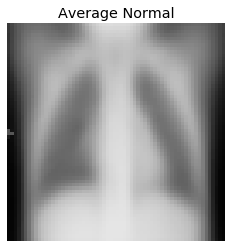

AttributeError: 'numpy.ndarray' object has no attribute 'savefig'

In [16]:
# Get the mean of each matrix on axis=0 and convert back to a 64,64 matrix
norm_mean = eda.find_mean_img(normal_images, 'Normal')
pneu_mean = eda.find_mean_img(pnemonia_images, 'Peumonia')

Our intuition from seeing 3 random images held true in the aggregate. The Average Pneumonia x-ray chest cavity is blurred, likely by the fluid and scarification from the their infection. 

Visual analysis built our intuition that there is a difference between between each pixel. We wanted to visualize the difference between the means of the images to demonstrate the regions where the differences in pixel value was greatest.

However, our pneumonia cases contained both viral and bacterial pneumonia patients. We decided to see if there was also a noticeable difference between those two groups. If there was, we would have to deal with in the modelling step.

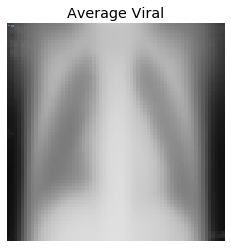

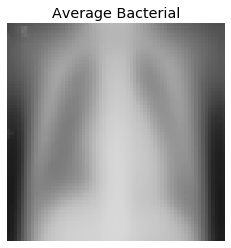

In [10]:
# Get viral and bacterial fn
viral_imgs = [fn for fn in os.listdir(f'{train_dir}/PNEUMONIA') if fn.endswith('.jpeg') and fn.find("virus") != -1]
bacterial_imgs = [fn for fn in os.listdir(f'{train_dir}/PNEUMONIA') if fn.endswith('.jpeg') and fn.find('bacteria') != -1]

# observe class imbalance
viral_size = len(viral_imgs)/(len(viral_imgs)+len(bacterial_imgs))
bacterial_size = len(bacterial_imgs)/(len(bacterial_imgs)+len(viral_imgs))

ax = sns.barplot(x = ['Viral', 'Bacterial'],
                 y = [viral_size, bacterial_size]);
ax.set_title("Class Imbalance Between Viral and Bacterial Pneumonia");

# get viral and bacterial full matrices
viral_fm = eda.image_to_matrix(f'{train_dir}/PNEUMONIA/', viral_imgs)
bacterial_fm = eda.image_to_matrix(f'{train_dir}/PNEUMONIA/', bacterial_imgs)

# Display the mean differences in the 
viral_mean = eda.find_mean_img(viral_fm, 'Viral')
bacterial_mean = eda.find_mean_img(bacterial_fm, 'Bacterial')

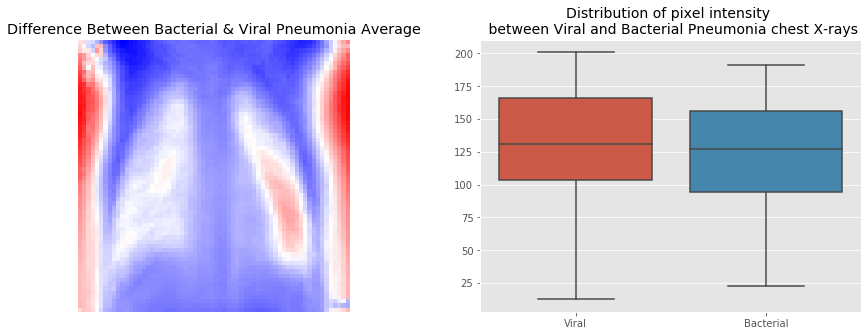

In [15]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15, 5))

contrast_mean = bacterial_mean - viral_mean
ax[0].imshow(contrast_mean, cmap='bwr')
ax[0].set_title(f'Difference Between Bacterial & Viral Pneumonia Average')
ax[0].axis('off')

# visualize pixel instensity distributions
viral_arr = viral_mean.ravel()
bac_arr = bacterial_mean.ravel()


# Create a dataframe
bac_vir = pd.DataFrame([(viral_arr),(bac_arr)]).T
bac_vir.columns = ['Viral', 'Bacterial']

sns.boxplot(data=bac_vir, ax=ax[1]);
ax[1].set_title("Distribution of pixel intensity \n between Viral and Bacterial Pneumonia chest X-rays", size=14);

Its seems that perhaps viral pneumonia is produces less fluid and scarring in lungs. This may be an issue in our modelling stage as the overall pixel within the lungs in the viral x rays is not as high as those with pnuemonia.

The pixel distributions in this case are perhaps misleading. It would seem that viral x rays are brighter over all but that runs counter to what we observed. It could be that patients who had bacterial pneumonia were simply younger over all and small and the xray didn't pick up as much of their bones as they still have a lot of cartiledge. However, since we don't have access to patient age, this is a confounding factor we can only speculate on. 

Now that we examined our subclasses of pneumonia, let's join them back together into one class and compare the means between Normal and Pneuomonia patients.

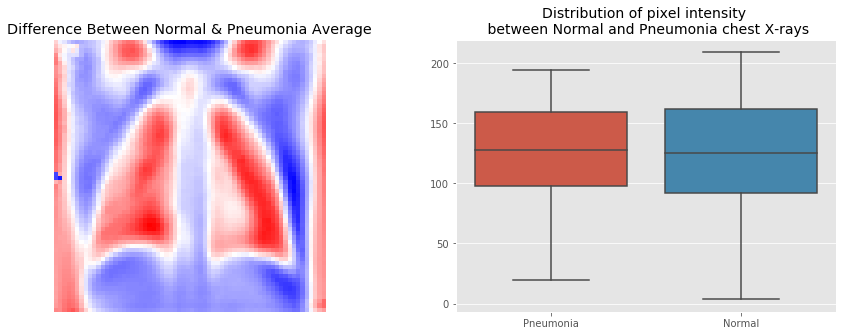

In [31]:
contrast_mean = pneu_mean - norm_mean


fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15, 5))

ax[0].imshow(contrast_mean, cmap='bwr')
ax[0].set_title(f'Difference Between Normal & Pneumonia Average')
ax[0].axis('off')

# flatten matrices
pnue_mean_arr = pneu_mean.ravel()
norm_mean_arr = norm_mean.ravel()


sick_healthy = pd.DataFrame([(pnue_mean_arr),(norm_mean_arr)]).T
sick_healthy.columns = ['Pneumonia', 'Normal']


sns.boxplot(data=sick_healthy, ax=ax[1]);
plt.title("Distribution of pixel intensity \n between Normal and Pneumonia chest X-rays", size=14);

Pixels that are blue are closer to 0 and pixels that are red are closer 255. We calculated the difference by subtracting the healthy individual's average pixel value away from the the pneuomonia patients pixel value. Therefore, the more red a region is, the brighter the region was in sick patients than in healthy ones. The result was that the chest cavity, specifically the lungs of the patients were far brighter in the pneumonia patients than in healthy individuals. 

In addition to the mean difference between pixels, we also were interested in the variance between pixels for each group. To do this, we repeated the above steps, defining a new function that takes as it's arguement full matrix and returns the variance of each pixel in the matrix.

In order to increase the brightness, we raised the pixel standard deviation to 1.1 so that the bright areas were amplified. 

When we look look at th box and whisker graph of the pixel distributions, a similar pattern emerges to what we observed via visual analysis. Though normal chest xrays have a larger range of pixel values, the median pixel intensity for pneumonia chest xrays was higher than Normal. In addition, the IQR was reduced in Pneumonia x-rays (70 vs 61). In addition, the max and min values between the classes was different. Normal x-rays had a maximal pixel intensity of 209 while Pnuemonia xrays had a maximal pixel instensity of 194.


It seems that Normal images on average have a wider range of pixel values than pneumonia images but pneumonia images have a greater mean and median overall, however, the results were not significant:

In [22]:
ttest = ttest_ind((pnue_mean_arr),(norm_mean_arr), equal_var=False) # parametric
manny = mannwhitneyu((pnue_mean_arr),(norm_mean_arr)) # non-parametric

print(f"The two sample independent ttest failed to reject the null hypotheis: p = {round(ttest[1], 2)}", end ='\n\n')

print(f"The Mann–Whitney U test also failed to reject the null hypotheis: p = {round(manny[1], 2)}")

The two sample independent ttest failed to reject the null hypotheis: p = 0.47

The Mann–Whitney U test also failed to reject the null hypotheis: p = 0.33


In [26]:
# Descriptive statistics between the images
IQR = sick_healthy.describe().loc['75%'] - sick_healthy.describe().loc['25%']
print(f"Inter Quartile Range of Pixel Intensity: \n\n{IQR}")
sick_healthy.describe()

Inter Quartile Range of Pixel Intensity: 

Pneumonia    61.482712
Normal       69.970358
dtype: float64


,Pneumonia,Normal
count,4096.000000,4096.000000
mean,123.181543,122.410553
std,45.474666,51.337497
min,19.471483,3.404922
25%,97.876579,91.786726
50%,127.727871,125.328487
75%,159.359291,161.757084
max,194.148911,209.061890


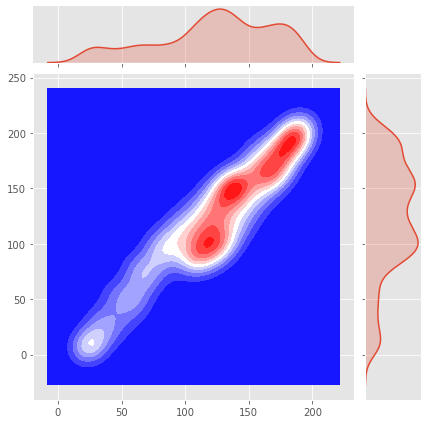

In [27]:
# Flatten out the mean matrices 
pnue_mean_arr = (pneu_mean.ravel())
norm_mean_arr = (norm_mean.ravel())

ax = sns.jointplot(x=pnue_mean_arr, y=norm_mean_arr, 
               kind='kde', cmap='bwr');



The multivariate KDE plot shows which intensities are common between the classes while displaying the distributions of both. The distributions don't look very different from one another which reinforces the statistical tests that failed to reject the null hypothesis.

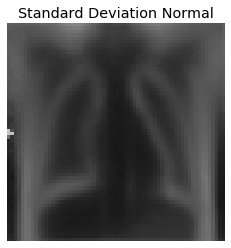

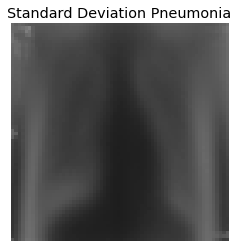

In [18]:
norm_std = eda.find_var_img(normal_images, 'Normal')
pneu_std = eda.find_var_img(pnemonia_images, 'Pneumonia')

The patients with pnuemonia had greater variation accross their entire lung area whereas healthy patients tended to have variation in the size of their lungs, given by the outline in the of the lung having a higher standard deviation. 

Similar to mean pixel intensity, let's look at the differences between the two classes in the standard deviation of the pixels

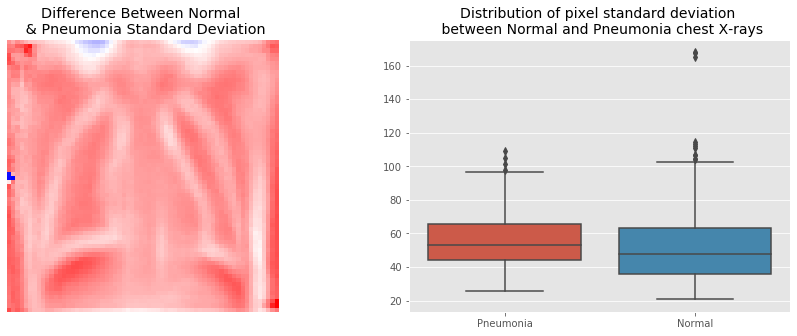

In [20]:
contrast_std = pneu_std -norm_std


fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15, 5))

ax[0].imshow(contrast_std, cmap='bwr')
ax[0].set_title(f'Difference Between Normal \n & Pneumonia Standard Deviation')
ax[0].axis('off')

# flatten matrices
pnue_std_arr = pneu_std.ravel()
norm_std_arr = norm_std.ravel()


sick_healthy = pd.DataFrame([(pnue_std_arr),(norm_std_arr)]).T
sick_healthy.columns = ['Pneumonia', 'Normal']


sns.boxplot(data=sick_healthy, ax=ax[1]);
plt.title("Distribution of pixel standard deviation \n between Normal and Pneumonia chest X-rays", size=14);
plt.savefig("./images/standardDiff.png")

Here, we can see that the overall shape of the lungs changed very little between the two classes. However, the pixel intensity within and around the lungs was much higher in the Pnuemonia class. This once again was to be expected. Pnuemonia doesn't effect all regions of the lungs uniformly. It can be more intense in specific regions however the lungs over all are similar in size whether or not you have an infection. 

A caveat to the above statement is that patients with pnuemonia's lungs appeared "longer" than those without. This is highlighted by the shadowy regions on either lower regions of the lung.  The reason for this is likely the accumulation of fluid at the base of the lungs being detected by the x ray.

Next, we wanted to use eigendecomposition/principal component analysis to find which features of the image stand out and potentially reduce the dimensions of our data set for future modelling. This process is also called eigenfaces, and was first usedin 1987 by Turk and Pentland for face classification. However it can be broadly used to extract the most important features from images in each class. 

To acheive this, we will use the sklaern PCA implementation but we will only look at eigenimages that explain 60% of the total varation in the dataset.

Number of Pneumonia PC:  7


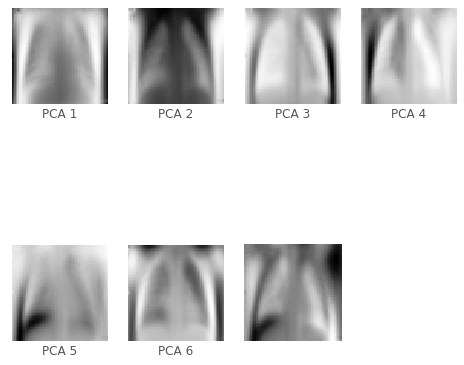

Number of Normal PC:  14


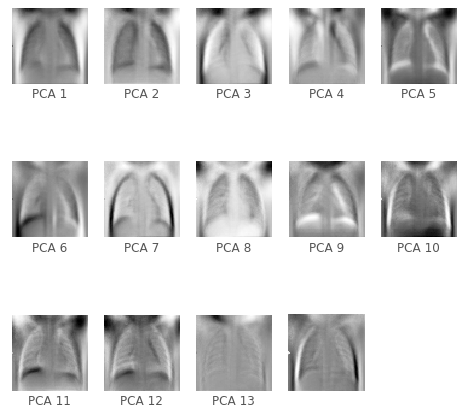

In [35]:
eda.plot_pca(eda.eigenimages(pnemonia_images, 'Pneumonia'))
eda.plot_pca(eda.eigenimages(normal_images, 'Normal')) 

Interestingly, in order to explain 60% of the variation in the data sets, you needed twice the number of PCA's from the healthy class than the sick class. A theorized reason for this is that since the healthy class had less variance over all, the difference between features was less impactful. 


Interestingly, PCA 1 of pnuemonia revealed that over all brightness of the image was indicative of the class. The next PCA highlights the size of the lungs themselves. Healthy PCA1, PCA2 and PCA3 on the otherhand are all highlighting well defined edges around the lungs. Likely, this is due to our previous finding that the variation around in the size of the lung larger than the variation within the lungs for healthy patients.


We hope that our cnn will be able to pull out those contours in the convolutions.

# Our takeaways from EDA:
- Class Imbalance:
    - There are 3x the number of x rays of infected lungs than healthy we will address this via:
        - Data Augmentation, though we are hesitant about using augmentation on medical images.
            - Rotations, shifts and inversions
        - Class weighting. We will calculate the inverse class frequency and use those as the weights in our model
- Feature Selection:
    - We hope to train our CNN to pick out 3 key features:
        - Cloudiness of the image/overall brightness
        - The dark well defined chest cavity of healthy people
        - The region at the base of the lungs corresponding to build up of fluids


## Importing our data for modeling

In [2]:
images = data.import_image_to_array('/src/data/',
         dir_names = ['train', 'test', 'val'],
         sub_dir_names = ['NORMAL', 'PNEUMONIA'],
         padding=False,
         shape=(224,224), test=False, grayscale = False)

Your relative directory is good, proceeding to import files...

Loading images from train
Finished loading images from NORMAL
Finished loading images from PNEUMONIA

Loading images from test
Finished loading images from NORMAL
Finished loading images from PNEUMONIA

Loading images from val
Finished loading images from NORMAL
Finished loading images from PNEUMONIA



### Splitting the train, test and validation data into just image arrays for modeling

In [3]:
X_train = np.array([i[1] for i in images['train']])  
y_train = np.array([i[2] for i in images['train']])

X_test = np.array([i[1] for i in images['test']])
y_test = np.array([i[2] for i in images['test']])

X_val = np.array([i[1] for i in images['val']])
y_val = np.array([i[2] for i in images['val']])

### Baseline Model

In [7]:
#baseline model- two convolution layers, maxpooling, one 32 node dense layer and the output

cnn = models.Sequential()

# Input convolution layer
cnn.add(layers.Conv2D(64, kernel_size= (3, 3), activation='relu', input_shape=(224, 224,  3)))

# Max pooling layer
cnn.add(layers.MaxPooling2D((2, 2)))

# Hidden convolution layer and pool
cnn.add(layers.Conv2D(32, kernel_size= (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))

# Output
cnn.add(layers.Dense(1, activation='sigmoid'))

# Compiling with stochastic gradient descent, optimized for accuracy
cnn.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [8]:
cnn1 = cnn.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=50,
                    validation_data=(X_val, y_val))

Epoch 1/5
105/105 [==============================] - 145s 1s/step - loss: 0.5007 - acc: 0.7655 - val_loss: 0.5940 - val_acc: 0.6875
Epoch 2/5
105/105 [==============================] - 141s 1s/step - loss: 0.3162 - acc: 0.8719 - val_loss: 0.7030 - val_acc: 0.6250
Epoch 3/5
105/105 [==============================] - 142s 1s/step - loss: 0.2309 - acc: 0.9086 - val_loss: 0.4124 - val_acc: 0.8125
Epoch 4/5
105/105 [==============================] - 140s 1s/step - loss: 0.1848 - acc: 0.9258 - val_loss: 0.4843 - val_acc: 0.8125
Epoch 5/5
105/105 [==============================] - 142s 1s/step - loss: 0.1620 - acc: 0.9354 - val_loss: 0.7232 - val_acc: 0.6250


In [9]:
results_test = cnn.evaluate(X_test, y_test)

20/20 [==============================] - 4s 213ms/step - loss: 0.8715 - acc: 0.7147


Our baseline model was able to reach 71% accuracy in just five epochs- not bad. We were ready to build a more elaborate model. 

## Creating a more optimized model

Next, we created a much more complex model. We expanded our metrics from just Accuracy to adding AUC and Recall. We changed our optimizer to Adam in order to reduce improve our learning rate. We created overlaps in our pools, added regularization layers and increased the number of graduated dense layers. We also calculated the inverse class frequency to further compensate for our class imbalance.

In [4]:
# calculate inverse frequency
pnue_frequency = sum(y_train)/len(y_train)
inv_pnue_frequency = 1/pnue_frequency
normal_frequency = (len(y_train)-sum(y_train))/len(y_train)
inv_normal_frequency = 1/normal_frequency
weights = {
    0: inv_normal_frequency,
    1: inv_pnue_frequency
    }

In [ ]:
# Setting an early stop feature
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

rms = tf.keras.optimizers.RMSprop(learning_rate=0.1)

cnn2 = models.Sequential()
# Input convolution layers
cnn2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3)))
cnn2.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Overlapped pooling
cnn2.add(layers.MaxPooling2D((2, 3)))

# First hidden convolution layers and pool
cnn2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn2.add(layers.MaxPooling2D((2, 3)))

# Second hidden convolution layers and pools
cnn2.add(layers.Conv2D(16, (6, 6), activation='relu'))
cnn2.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn2.add(layers.MaxPooling2D((2, 3)))

# Flatten layer
cnn2.add(layers.Flatten())

# 3 Graduated densely connected layers with graduated regularization
cnn2.add(layers.Dense(64, activation='relu'))
cnn2.add(layers.Dropout(.5))
cnn2.add(layers.Dense(32, activation='relu'))
cnn2.add(layers.Dropout(.3))
cnn2.add(layers.Dense(16, activation='relu'))
cnn2.add(layers.Dropout(.1))

# Output layer
cnn2.add(layers.Dense(1, activation='sigmoid'))
cnn2.compile(loss='binary_crossentropy',
              optimizer= 'Adam',
              metrics=['acc', 'Recall', 'AUC'])

# Fitting the model with our additional class weight parameter
cnn3 = cnn2.fit(X_train, y_train,
               epochs=20,
               batch_size=50,
               validation_data = (X_val, y_val), 
               class_weight=weights,
               verbose=True,
               callbacks = callback)

In [4]:
#Importing this exact model from a different notebook 

cnn2 = models.load_model('src/models/2020-12-06homemade.HDF5')

In [5]:
#evaluating the model on the test set

results_test2 = cnn2.evaluate(X_test, y_test)

20/20 [==============================] - 12s 620ms/step - loss: 0.9303 - acc: 0.7901 - recall: 0.9769 - auc: 0.8848


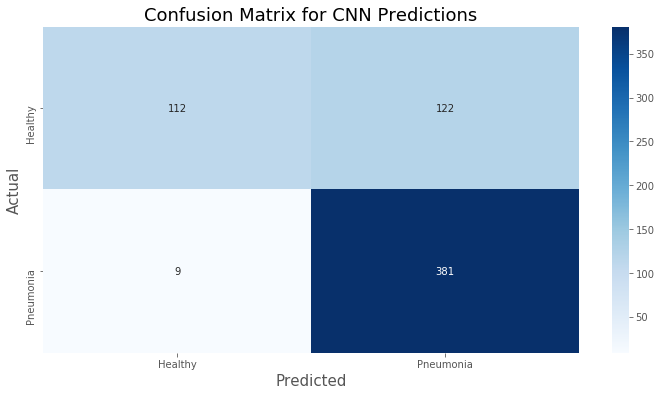

In [35]:
# Generating a confusion matrix from the model predictions

predictions = graphs.get_labels(cnn2, X_test, 0.5)
graphs.plot_cmatrix(y_test, predictions)

AUC: 0.9272901599824677


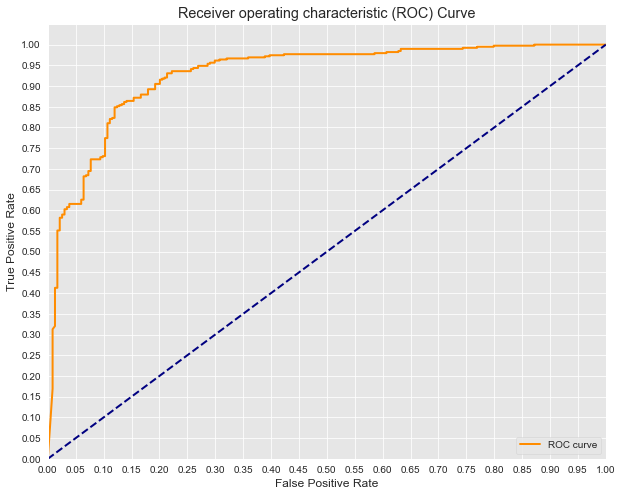

In [43]:
# Plotting the ROC curve of our predictions

graphs.plot_roc_curve(y_test, cnn2.predict(X_test))

## Transfer Learning

Though our initial results are looking good, we decided to bring in some pre-trained models and try to use them in conjuction- both to get ideas about the architecture that could work the best for us and to possibly use a stacking classifier to combine a variety of models for the best possible result.

### VGG16

A modified version of AlexNet, VGG16 uses a massive array of 3x3 convolution layers. We fitted a few of our own densely connected output layers and trained them on the data. 

In [ ]:
VGG16_model = VGG16(input_shape = (224, 224, 3), 
                    # Shape of our images
                    include_top = False, 
                    # Leave out the last fully connected layer
                    weights = 'imagenet')

for layer in VGG16_model.layers:
    layer.trainable = False
#making the existing layers untrainable in order to preserve them

# Flatten the output layer to 1 dimension
x = layers.Flatten()(VGG16_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a second fully connected layer with 256 hidden units and ReLU activation
x = layers.Dense(256, activation='relu')(x)

# Dropout with a rate of 0.3
x = layers.Dropout(.3)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

vggmodel = tf.keras.models.Model(VGG16_model.input, x)

vggmodel.compile(optimizer = 'Adam', 
              loss = 'binary_crossentropy',
              metrics = ['acc', 'Recall', 'AUC'])

vgghist = vggmodel.fit(X_train, y_train, 
                       validation_data = (X_val, y_val), 
                       epochs = 10, 
                       batch_size=50, 
                       class_weight=weights, 
                       callbacks= callback)

In [5]:
#Importing this completed model from another notebook

vggmodel = models.load_model('src/models/2020-12-06vgg.HDF5')

In [16]:
# evaluating the model on the test set

results_test3 = vggmodel.evaluate(X_test, y_test)

20/20 [==============================] - 73s 4s/step - loss: 0.4109 - acc: 0.8830 - recall_1: 0.9897 - auc_1: 0.9480


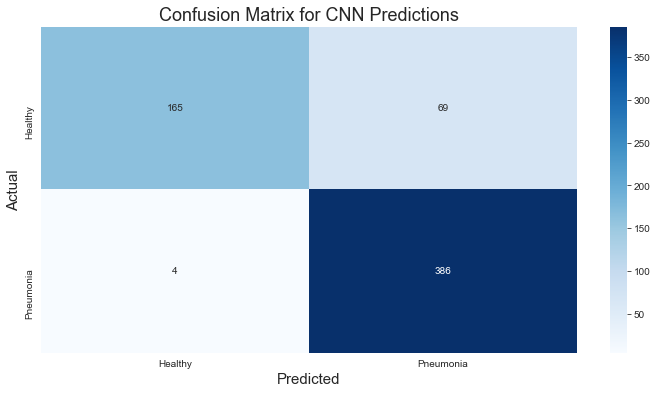

In [28]:
# Generating a confusion matrix from the model predictions

predictions = graphs.get_labels(vggmodel, X_test, 0.5)
graphs.plot_cmatrix(y_test, predictions)

AUC: 0.9605522682445761


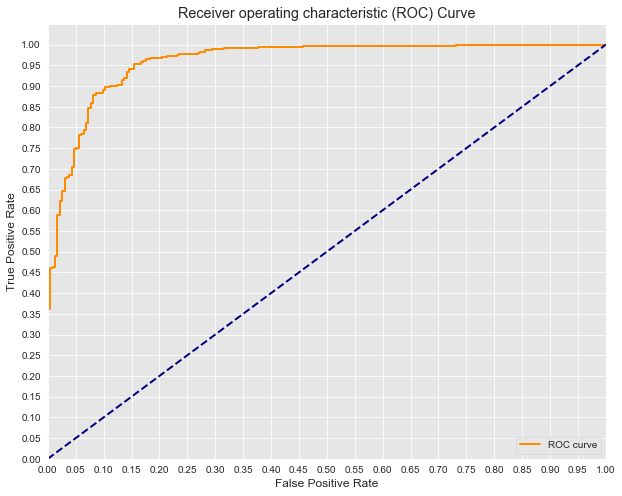

In [42]:
# Plotting the ROC curve of our predictions

graphs.plot_roc_curve(y_test, vggmodel.predict(X_test))

### DenseNet121

Unlike our other models, DenseNet121 uses a single convolution layer followed by a series of densely connected layers. We wanted to generate a variety of different predictions for our eventual voting classifier, and DenseNet seemed like an obvious choice to diversify them. 

In [ ]:
densebase = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='Max',
    classes=2,)

for layer in densebase.layers:
    layer.trainable = False

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Flatten the output layer to 1 dimension
a = layers.Flatten()(densebase.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
a = layers.Dense(512, activation='relu')(a)

# Add a dropout rate of 0.5
a = layers.Dropout(0.5)(a)

# Add a second fully connected layer with 256 hidden units and ReLU activation
a = layers.Dense(256, activation='relu')(a)

a = layers.Dropout(.3)(a)
# Add a final sigmoid layer for classification
a = layers.Dense(1, activation='sigmoid')(a)

densemodel = tf.keras.models.Model(densebase.input, a)

densemodel.compile(optimizer = 'sgd', loss = 'binary_crossentropy',metrics = ['acc', 'Recall', 'AUC'])

densehist = densemodel.fit(
                      X_train, y_train, 
                      validation_data = (X_val, y_val), 
                      epochs = 25, 
                      batch_size=25, 
                      class_weight=weights)

In [6]:
# Loading in a trained version of this model from another notebook

densemodel = models.load_model('src/models/2020-12-05densenet.HDF5')

In [31]:
# evaluating the model on the test set

results_test4 = densemodel.evaluate(X_test, y_test)

20/20 [==============================] - 39s 2s/step - loss: 0.9563 - acc: 0.8734 - recall_4: 0.9923 - auc_4: 0.9044


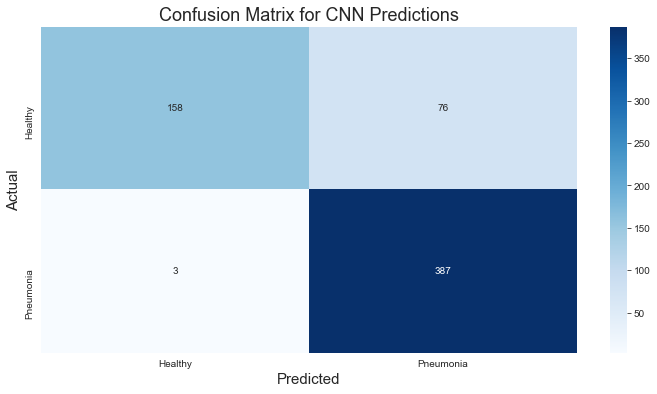

In [33]:
# Generating a confusion matrix from the model predictions

predictions = graphs.get_labels(densemodel, X_test, 0.5)
graphs.plot_cmatrix(y_test, predictions)

AUC: 0.9573580977427132


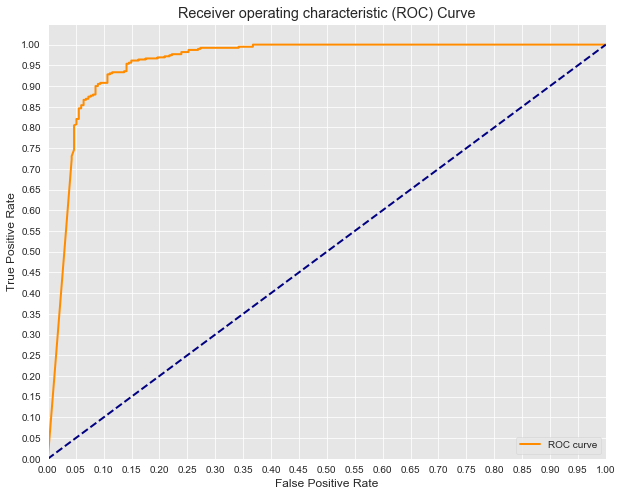

In [41]:
# Plotting the ROC curve of our predictions

graphs.plot_roc_curve(y_test, densemodel.predict(X_test))

### MobileNetV2

MobilenetV2 utilizes depth-wise convolutions and linear bottlenecks between convolution blocks to maximize classification on RGB images. With it's stripped down architecture and great performance, it made a fantastic addition to our ensemble model.

In [ ]:
mobile = tf.keras.applications.MobileNetV2(
                input_shape=(224, 224, 3), 
                alpha=1.0, 
                include_top=False, 
                weights='imagenet',
                input_tensor=None, 
                pooling='max', 
                classes=2)

for layer in mobile.layers:
    layer.trainable = False

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Flatten the output layer to 1 dimension
a = layers.Flatten()(mobile.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
a = layers.Dense(512, activation='relu')(a)

# Add a dropout rate of 0.5
a = layers.Dropout(0.5)(a)

# Add a second fully connected layer with 256 hidden units and ReLU activation
a = layers.Dense(256, activation='relu')(a)

a = layers.Dropout(.3)(a)
# Add a final sigmoid layer for classification
a = layers.Dense(1, activation='sigmoid')(a)

mobilemodel = tf.keras.models.Model(mobile.input, a)

mobilemodel.compile(optimizer = 'Adam', loss = 'binary_crossentropy',metrics = ['acc', 'Recall', 'AUC'])

mobilehist = mobilemodel.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 20, batch_size=25, class_weight=weights)

In [7]:
# Importing a trained version of this model

mobilemodel = models.load_model('src/models/2020-12-06mobilenetv2.HDF5')

In [41]:
mobile_test = mobilemodel.evaluate(X_test, y_test)

20/20 [==============================] - 10s 518ms/step - loss: 0.4324 - acc: 0.8814 - recall_6: 0.9795 - auc_6: 0.9485


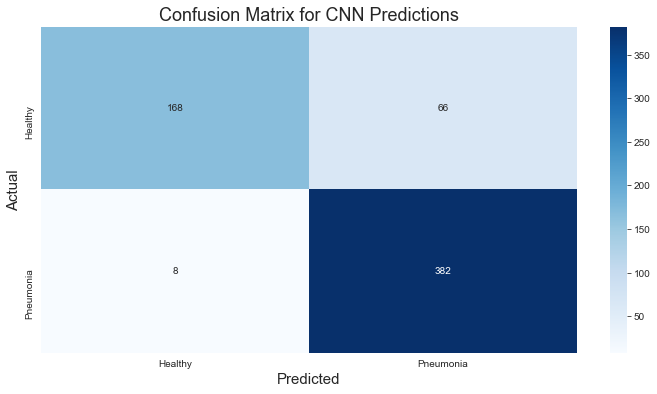

In [42]:
# Generating a confusion matrix from the model predictions

predictions = graphs.get_labels(mobilemodel, X_test, 0.5)
graphs.plot_cmatrix(y_test, predictions)

AUC: 0.9624917817225509


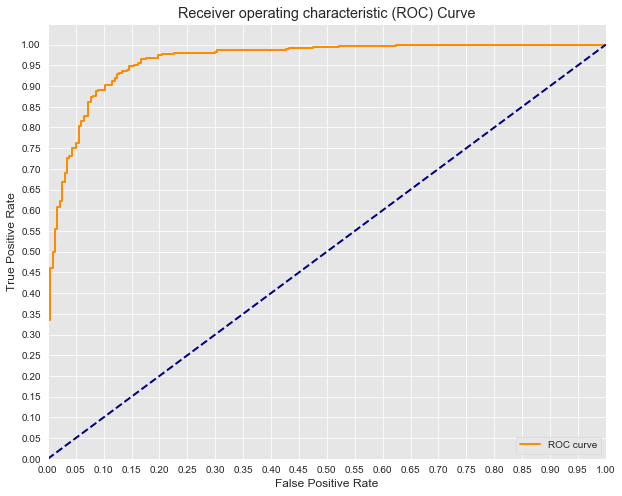

In [40]:
# Plotting the ROC curve of our predictions

graphs.plot_roc_curve(y_test, mobilemodel.predict(X_test))

### Ensemble Classifier

Finally, we generated an ensemble of our previous CNNs' predictions in order to maximize our accuracy and recall. 

In [8]:
from scipy import stats

def stacked_classifier(list_of_models,
                       X_test,
                       y_test,
                       model_input_shape=None, 
                       model_weights=None,
                       threshold=0.5,
                       soft_voting=True):
    """
    given a list of classifiers, returns a hard or soft voting array of predictions
    """
    # instantiate a prediction matrix
    m = len(X_test) # matrix rows
    n = len(list_of_models) # matrix columns
    prediction_matrix = np.ones((m,n))
    # update predictions matrix
    for i in range(0,n):
        print(f"Generating predictions for model {i+1}")
        model = list_of_models[i]
        p = model.predict(X_test)
        prediction_matrix[:,i] *= p.ravel()
        print(f"Finished prediction on model {i+1}")
    # Adjust the weights of each prediction
    if model_weights:
        print("Adjusting weights of the classifier's predictins", end="/n/n")
        for i, weight in enumerate(model_weights):
            prediction_matrix[:,i] *= model_weights[weight]
    if not soft_voting:
        print("Returning hard voting predictions")
        preditions =  prediction_matrix > threshold
        return stats.mode(predictions, axis=1)
    else:
        print("Returning soft voting predictions")
        probabilities = np.mean(prediction_matrix, axis=1)
        predictions = probabilities > threshold
        return predictions, probabilities, prediction_matrix

In [9]:
ensemble_preds, probabilities, prediction_matrix = stacked_classifier([mobilemodel, densemodel, vggmodel],
                       X_test,
                       y_test,
                       model_input_shape=(224,224,3), 
                       model_weights=None,
                       threshold=0.65,
                       soft_voting=True)

Generating predictions for model 1
Finished prediction on model 1
Generating predictions for model 2
Finished prediction on model 2
Generating predictions for model 3
Finished prediction on model 3
Returning soft voting predictions


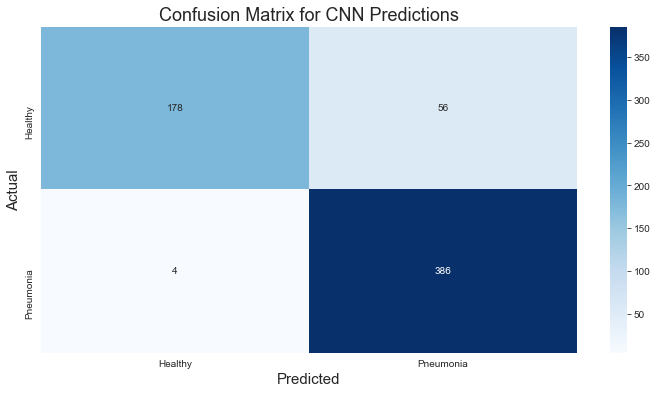

In [56]:
graphs.plot_cmatrix(y_test,ensemble_preds)

In [15]:
ensemblepreds = ensemble_preds.reshape(624, 1)
cnnpreds = cnn2.predict(X_test).reshape(624, 1)

In [18]:
full_matrix = np.concatenate((prediction_matrix, probabilities.reshape(624,1), cnnpreds), axis = 1)

Text(0, 0.5, 'Number of Predictions')

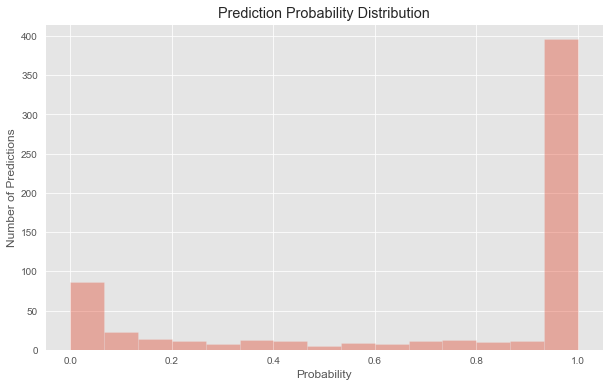

In [25]:
#hist of probabilities
fig, ax = plt.subplots(figsize = (10,6))
sns.distplot(probabilities, kde = False, bins = 15, ax= ax)
plt.style.use('ggplot')
plt.title('Prediction Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Number of Predictions')

Looking at the histogram distribution we can see that the mid range around 0.5-0.6 has very few predictions. By moving our threshhold with this range, we were able to reduce our false positives by 10 while retaining a 99% recall.

AUC: 0.9624917817225509
AUC: 0.9573580977427132
AUC: 0.9605522682445761
AUC: 0.9691540653079115
AUC: 0.9272901599824677


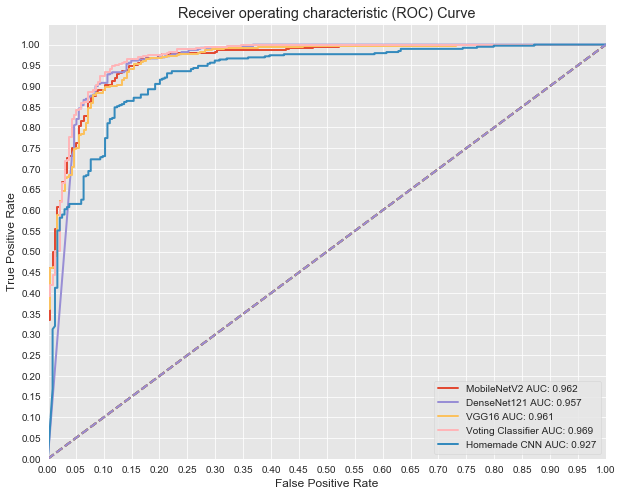

In [19]:
names = ['MobileNetV2', 'DenseNet121', 'VGG16', 'Voting Classifier', 'Homemade CNN']

plt.figure(figsize=(10, 8))
for i, model in enumerate(names):    
    predictions = full_matrix[:,i]
    fpr, tpr, threshholds = roc_curve(y_test, predictions)
    
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
    
    print('AUC: {}'.format(auc(fpr, tpr)))
    
    lw = 2
    plt.plot(fpr, tpr,
         lw=lw, label=f'{names[i]} AUC: {round(auc(fpr, tpr), 3)}')
    plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()

In [15]:
fpr, tpr, threshholds = roc_curve(y_test, probabilities)

print(accuracy_score(y_test, ensemble_preds))
print(recall_score(y_test, ensemble_preds))
print(auc(fpr, tpr))

0.9038461538461539
0.9897435897435898
0.9691540653079115


## Evaluating False Positives and False Negatives

Our model has performed well, but we wanted to examine its incorrect predictions to see if any obvious pattern is present.

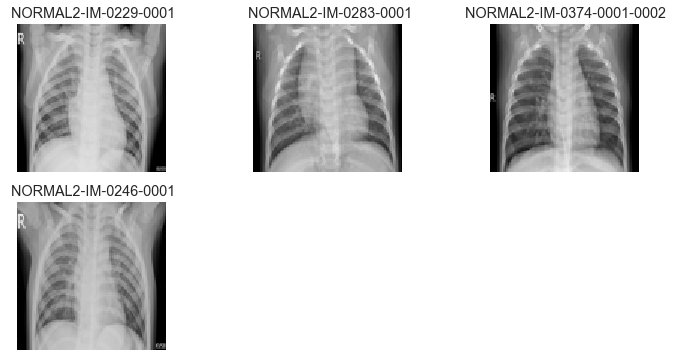

In [34]:
# Visually examining False Positives

fp = graphs.see_false_positives(images, ensemble_preds, PATH= './src/data/test/NORMAL/', num_images=4)

In [35]:
# Listing image names for further processing

fp_full_matrix = eda.image_to_matrix('./src/data/test/NORMAL/', fp)

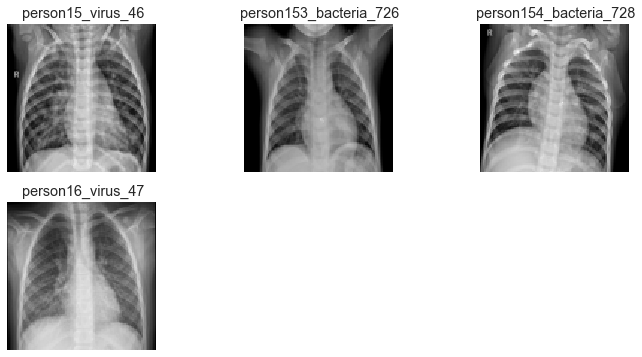

In [36]:
# Visually examining our False Negatives

fn = graphs.see_false_negatives(images, ensemble_preds, PATH= './src/data/test/PNEUMONIA/', num_images=4)

In [37]:
# Pulling filenames for further processing

fn_full_matrix = eda.image_to_matrix('./src/data/test/PNEUMONIA/', fn)

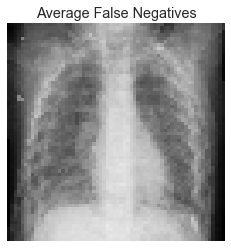

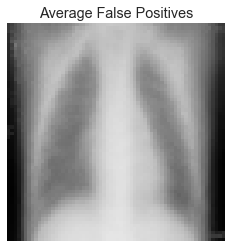

In [38]:
# Generating the mean images of all false negatives and false positives

avg_false_neg = eda.find_mean_img(fn_full_matrix, title= 'False Negatives')
avg_false_pos = eda.find_mean_img(fp_full_matrix, title= 'False Positives')

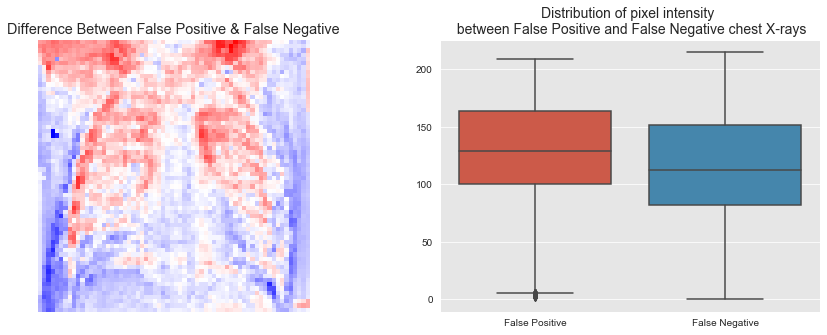

In [40]:
# Visualizing the difference between the average false positive and average false negative

contrast_mean = avg_false_pos - avg_false_neg


fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15, 5))

ax[0].imshow(contrast_mean, cmap='bwr')
ax[0].set_title(f'Difference Between False Positive & False Negative')
ax[0].axis('off')

# flatten matrices
fp_mean_arr = avg_false_pos.ravel()
fn_mean_arr = avg_false_neg.ravel()


sick_healthy = pd.DataFrame([(fp_mean_arr),(fn_mean_arr)]).T
sick_healthy.columns = ['False Positive', 'False Negative']


sns.boxplot(data=sick_healthy, ax=ax[1]);
plt.title("Distribution of pixel intensity \n between False Positive and False Negative chest X-rays", size=14);

## Conclusions

Though our AUC suffered, we were able to reduce our false positives significantly while retaining a 99% recall score using our ensemble method. 

Using this model, a prediction which could correctly identify 99% of pneumonia cases can be generated. We believe that with these predictions, a radiologist or physician could quickly triage a large intake of chest x-rays and in doing so rapidly assess the most severe cases and treat them. 